## 事故与异常识别

In [22]:
import pandas as pd
import numpy as np

df = pd.read_excel('data/处理文档.xlsx', sheet_name = 'Sheet1', skiprows=3)

df = df.rename(columns={'饲喂日期': 'Date', 
                        '每日采食总量(Kg)': 'Food/kg', 
                        '每日喂水总量(L)': 'Water/L', 
                        '水料比': 'Ratio', 
                        '死亡数': 'n_case',
                        '事故类型': 'Type',
                        '转舍前日龄':'before_age', 
                        '转舍日龄':'after_age', 
                        '总日龄': 'total_age', 
                        '存栏数': 'num',
                        '均采食量/kg': 'avg_food_kg', 
                        '均喂水量/L': 'avg_water_l', 
                        '应采食量/kg': 'reg_food_kg', 
                        '是否治疗': 'if_cure'
                        })

df['y_bool'] = (np.where(df['n_case'] > 0, 1, 0)) # | (df['if_cure'] == 1)
df['Date'] = pd.to_datetime(df['Date'])

df = df.iloc[::-1].reset_index(drop=True)
# Get x values for Disease event
# mask = (df['y_bool'] == 1) | (df['if_cure'] == 1)
mask = (df['y_bool'] == 1) 
x_position = df.loc[mask, 'Date']

In [23]:
sum(df['y_bool'])

13

In [24]:
df.columns

Index(['Date', 'Food/kg', 'Water/L', 'Ratio', 'before_age', 'after_age',
       'total_age', 'num', 'avg_food_kg', 'avg_water_l', 'reg_food_kg',
       'n_case', 'if_cure', 'Type', 'y_bool'],
      dtype='object')

总趋势变化

In [25]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']    # 设置英文默认字体
plt.rcParams['axes.unicode_minus'] = False      # 显示负号

CN_font = font_manager.FontProperties(fname='C:/Windows/Fonts/simhei.ttf')

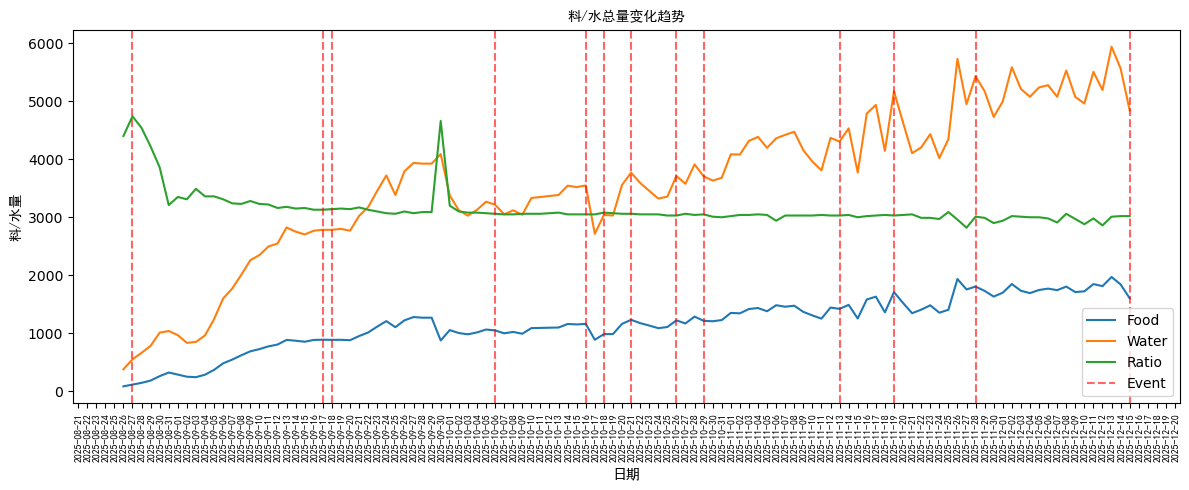

In [26]:
import matplotlib.dates as mdates


# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# df = df.dropna(subset=['Date'])      # 防止 NaT
# df['Date'] = df['Date'].dt.tz_localize(None)

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Food/kg'], label='Food')
plt.plot(df['Date'], df['Water/L'], label='Water')
plt.plot(df['Date'], df['Ratio'] * 1000, label='Ratio')
for i, x in enumerate(x_position):
    plt.axvline(x=x, color='red', linestyle='--', alpha=0.6, label='Event' if i == 0 else None)
plt.xlabel('日期', fontproperties=CN_font)
plt.ylabel('料/水量', fontproperties=CN_font)
plt.title('料/水总量变化趋势', fontproperties=CN_font)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=90, fontproperties=CN_font, fontsize=7)
plt.legend()
plt.tight_layout()
plt.show()

### 回归曲线拟合，残差相关性分析

利用回归曲线剔除生长趋势（总体趋势），寻找残差（置信带）与疾病事件的关联关系

#### 多项式回归 - 料

                            OLS Regression Results                            
Dep. Variable:            avg_food_kg   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     967.2
Date:                Thu, 25 Dec 2025   Prob (F-statistic):           7.56e-78
Time:                        10:02:52   Log-Likelihood:                 50.711
No. Observations:                 112   AIC:                            -93.42
Df Residuals:                     108   BIC:                            -82.55
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8151      0.015    122.599      0.0

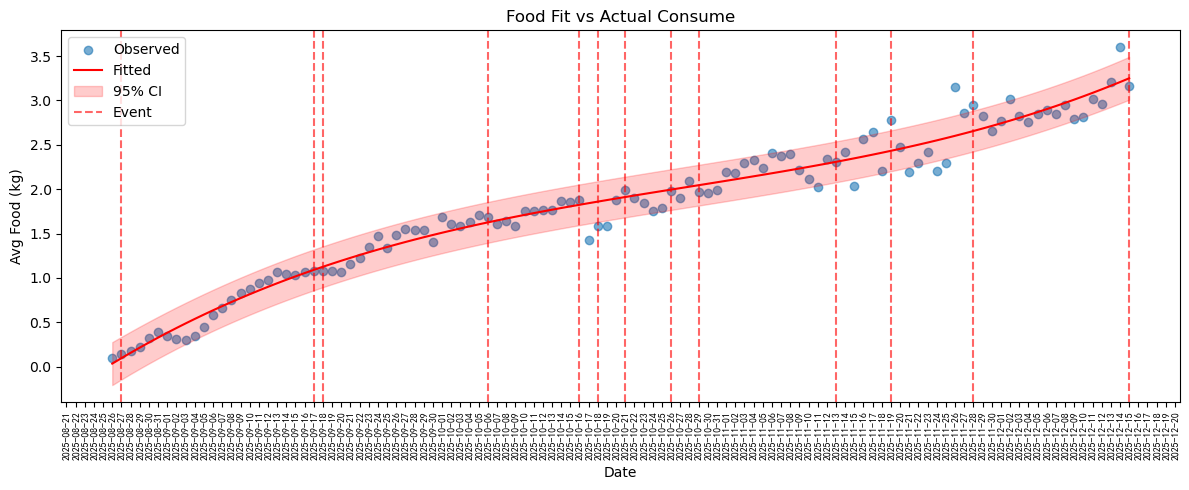

In [27]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

X = df[['total_age']]
y = df['avg_food_kg']

# 生成多项式特征（degree=2 或 3）
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# 标准化
from sklearn.preprocessing import StandardScaler
X_poly = StandardScaler().fit_transform(X_poly)

# statsmodels 回归
X_poly_sm = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_poly_sm).fit()
print(model_poly.summary())

pred = model_poly.get_prediction(X_poly_sm)
pred_summary = pred.summary_frame(alpha=0.15)
print(model_poly.summary())

df["food_fit"] = pred_summary["mean"]
df["ci_lower"] = pred_summary["mean_ci_lower"]
df["ci_upper"] = pred_summary["mean_ci_upper"]

df["pred_lower_food"] = pred_summary["obs_ci_lower"]  # 预测区间下界
df["pred_upper_food"] = pred_summary["obs_ci_upper"]  # 预测区间上界

plt.figure(figsize=(12,5))
plt.scatter(df['Date'], y, alpha=0.6, label="Observed")
plt.plot(df['Date'], df['food_fit'], color='red', label="Fitted")
plt.fill_between(
    df['Date'],
    df['pred_lower_food'],
    df['pred_upper_food'],
    color='red',
    alpha=0.2,
    label="95% CI"
)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Avg Food (kg)")
plt.title('Food Fit vs Actual Consume')
x_mask = df.loc[mask, 'Date']
for i, x in enumerate(x_mask):
    plt.axvline(x, color='red', linestyle='--', alpha=0.6, label='Event' if i == 0 else None)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=90, fontproperties=CN_font, fontsize=7)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
standard_food = pd.DataFrame(
    {
        'age': df['total_age'],
        'food_e': df["food_fit"],
        'food_lower': df['pred_lower_food'],
        'food_upper': df['pred_upper_food'],
    }
)

In [29]:
standard_food.to_excel('data/std_food_table.xlsx', index=False)

#### 尝试多项式回归 - 水

                            OLS Regression Results                            
Dep. Variable:            avg_water_l   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     737.8
Date:                Thu, 25 Dec 2025   Prob (F-statistic):           9.23e-72
Time:                        10:02:53   Log-Likelihood:                -83.275
No. Observations:                 112   AIC:                             174.5
Df Residuals:                     108   BIC:                             185.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5433      0.049    113.191      0.0

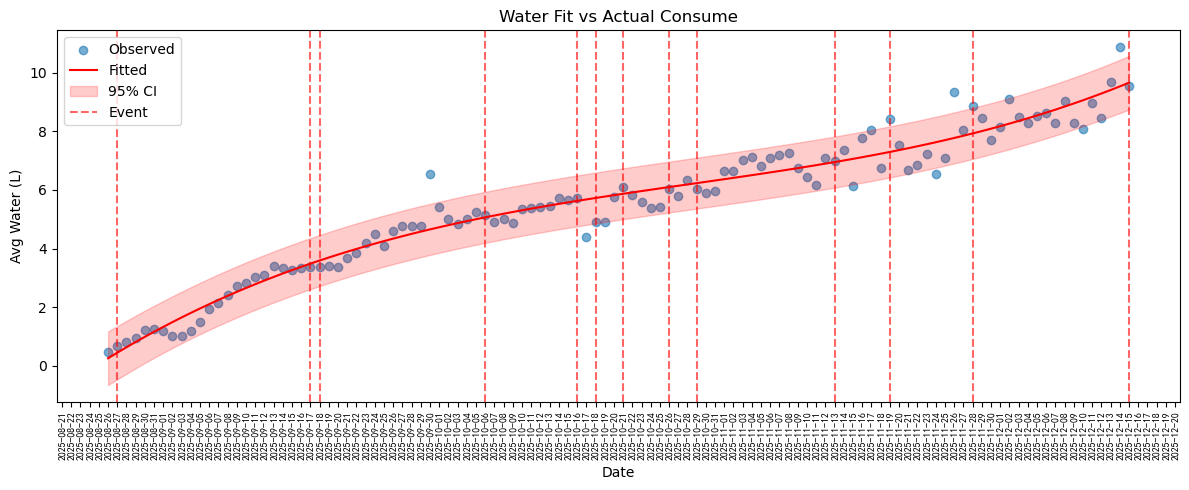

In [30]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

X = df[['total_age']]
y = df['avg_water_l']

# 生成多项式特征（degree=2 或 3）
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# 标准化
from sklearn.preprocessing import StandardScaler
X_poly = StandardScaler().fit_transform(X_poly)

# statsmodels 回归
X_poly_sm = sm.add_constant(X_poly)
model_water = sm.OLS(y, X_poly_sm).fit()
print(model_water.summary())

pred = model_water.get_prediction(X_poly_sm)
pred_summary = pred.summary_frame(alpha=0.1)
print(model_water.summary())

df["water_fit"] = pred_summary["mean"]
df["pred_lower_water"] = pred_summary["obs_ci_lower"]  # 预测区间下界
df["pred_upper_water"] = pred_summary["obs_ci_upper"]  # 预测区间上界

plt.figure(figsize=(12,5))
plt.scatter(df['Date'], y, alpha=0.6, label="Observed")
plt.plot(df['Date'], df['water_fit'], color='red', label="Fitted")
plt.fill_between(
    df['Date'],
    df['pred_lower_water'],
    df['pred_upper_water'],
    color='red',
    alpha=0.2,
    label="95% CI"
)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Avg Water (L)")
plt.title('Water Fit vs Actual Consume')
x_mask = df.loc[mask, 'Date']
for i, x in enumerate(x_mask):
    plt.axvline(x, color='red', linestyle='--', alpha=0.6, label='Event' if i == 0 else None)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 修改x坐标系显示，以天为单位
plt.xticks(rotation=90, fontproperties=CN_font, fontsize=7)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
standard_water = pd.DataFrame(
    {
        'age': df['total_age'],
        'water_e': df['water_fit'],
        'water_lower': df['pred_lower_water'],
        'water_upper': df['pred_upper_water'],
    }
)

standard_water.to_excel('data/std_water_table.xlsx', index=False)

残差相关性 - 直观时序图

In [32]:
df.columns

Index(['Date', 'Food/kg', 'Water/L', 'Ratio', 'before_age', 'after_age',
       'total_age', 'num', 'avg_food_kg', 'avg_water_l', 'reg_food_kg',
       'n_case', 'if_cure', 'Type', 'y_bool', 'food_fit', 'ci_lower',
       'ci_upper', 'pred_lower_food', 'pred_upper_food', 'water_fit',
       'pred_lower_water', 'pred_upper_water'],
      dtype='object')

In [33]:
set(df['Type'])

{-1, 0, 1, 2, 3, 4, 9}

In [34]:
df.head()

,Date,Food/kg,Water/L,Ratio,before_age,after_age,total_age,num,avg_food_kg,avg_water_l,...,Type,y_bool,food_fit,ci_lower,ci_upper,pred_lower_food,pred_upper_food,water_fit,pred_lower_water,pred_upper_water
0,2025-08-26,86.4,380.0,4.40,25,1,26,828,0.10,0.46,...,-1,0,0.035026,-0.048038,0.118090,-0.206850,0.276902,0.255569,-0.659989,1.171127
1,2025-08-27,116.4,552.0,4.74,25,2,27,827,0.14,0.67,...,9,1,0.096436,0.018790,0.174081,-0.143633,0.336505,0.445186,-0.463532,1.353905
2,2025-08-28,146.4,664.0,4.54,25,3,28,827,0.18,0.80,...,-1,0,0.156415,0.083850,0.228980,-0.082059,0.394889,0.630235,-0.272447,1.532917
3,2025-08-29,186.0,784.0,4.22,25,4,29,827,0.22,0.95,...,-1,0,0.214987,0.147162,0.282811,-0.022088,0.452061,0.810786,-0.086599,1.708171
4,2025-08-30,262.0,1012.0,3.86,25,5,30,827,0.32,1.22,...,-1,0,0.272174,0.208746,0.335603,0.036320,0.508029,0.986915,0.094148,1.879682


In [35]:
color_map_event = {
    1: 'green',
    2: 'purple',
    3: 'orange',
    4: 'blue',
    # 5: '',
    9: 'black',
    -1: 'yellow',

}
type_map_event = {
    1: '发白',
    2: '呼吸道疾病',
    3: '应激',
    4: '胀气',
    # 5: 'purple',
    9: '猝死',

    -1: '治疗'
}
used_labels = set()

In [36]:
sum(df['y_bool'])

13

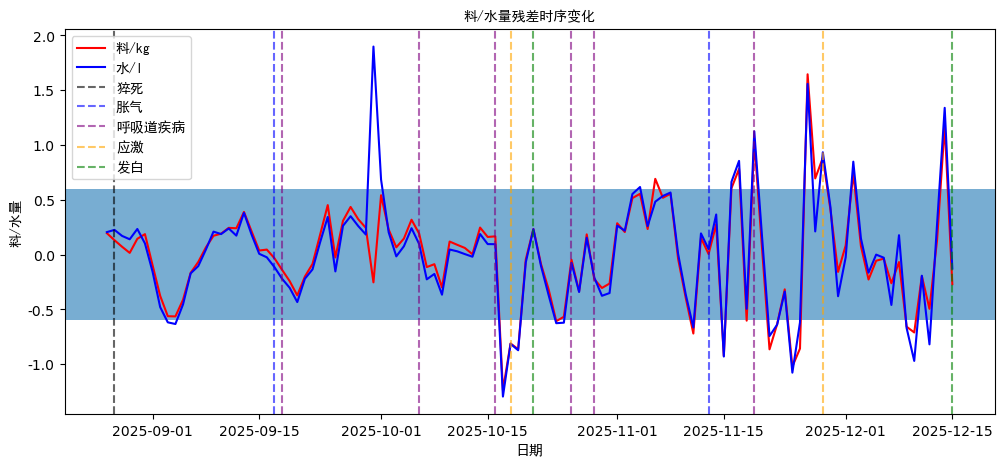

In [37]:
df['food_resi'] = df['avg_food_kg'] - df['food_fit']
df['water_resi'] = df['avg_water_l'] - df['water_fit']

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['food_resi']*3, color = 'red', label='料/kg')
plt.plot(df['Date'], df['water_resi'], color = 'blue', label='水/l')

used_labels = set()

for x in x_mask:
    event_type = df.loc[df['Date'] == x, 'Type'].iloc[0]    # 意外编号（int）
    event_legend = type_map_event[event_type]       # 意外类型（str）
    color = color_map_event.get(event_type, 'black')

    label = event_legend if event_legend not in used_labels else None
    used_labels.add(event_legend)

    plt.axvline(
        x,
        color=color,
        linestyle='--',
        alpha=0.6,
        label=label,
        
    )
# 添加残差参考区间
plt.axhspan(-0.6, 0.6, alpha=0.6)

# 图坐标轴绘制
plt.xlabel('日期', fontproperties=CN_font)
plt.ylabel('料/水量', fontproperties=CN_font)
plt.title('料/水量残差时序变化', fontproperties=CN_font)
plt.legend(prop = CN_font)
plt.show()


定量计算

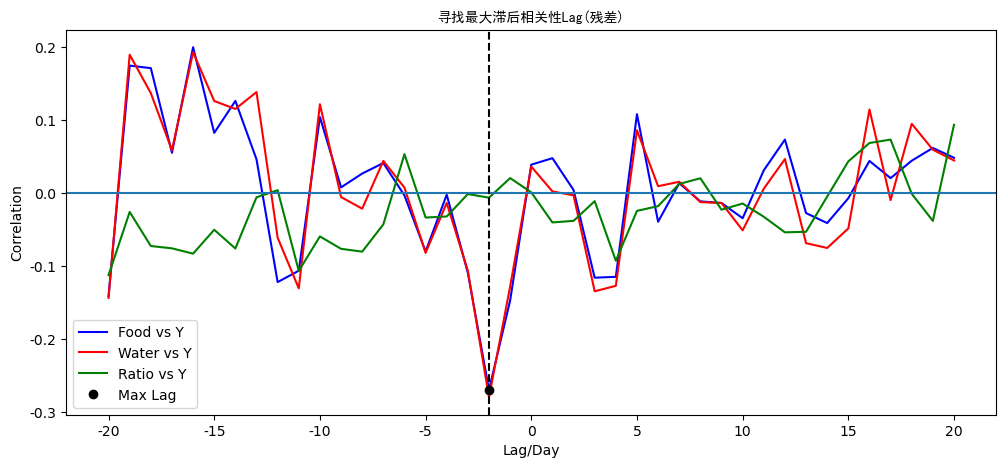

In [38]:
def lagged_corr(x, y, max_lag=20):
    """
    x 和 y 在 [-max_lag, max_lag] 范围内的滞后相关性
    """
    lags = range(-max_lag, max_lag + 1)
    corrs = []

    for lag in lags:
        corr = x.shift(lag).corr(y, method='spearman')
        corrs.append(corr)
    
    return pd.Series(corrs, index=lags)

lag_A_Y = lagged_corr(df['food_resi'], df['y_bool'])
lag_B_Y = lagged_corr(df['water_resi'], df['y_bool'])
lag_C_Y = lagged_corr(df['Ratio'], df['y_bool'])

# 绘制整体lag曲线
plt.figure(figsize=(12,5))
plt.plot(lag_A_Y.index, lag_A_Y.values, color = 'blue', label='Food vs Y')
plt.plot(lag_B_Y.index, lag_B_Y.values, color = 'red', label='Water vs Y')
plt.plot(lag_C_Y.index, lag_C_Y.values, color = 'green', label='Ratio vs Y')
plt.axhline(0)
plt.xlabel("Lag/Day")
plt.ylabel("Correlation")


# 绘制最大点
max_id = abs(lag_A_Y).idxmax()
max_value = lag_A_Y[max_id]
plt.plot(max_id, max_value, 'o', color='black', label='Max Lag')
plt.axvline(max_id, linestyle='--', color='black')
plt.title('寻找最大滞后相关性Lag(残差)', fontproperties = CN_font)
plt.legend()
plt.show()

定量计算 - 残差取绝对值

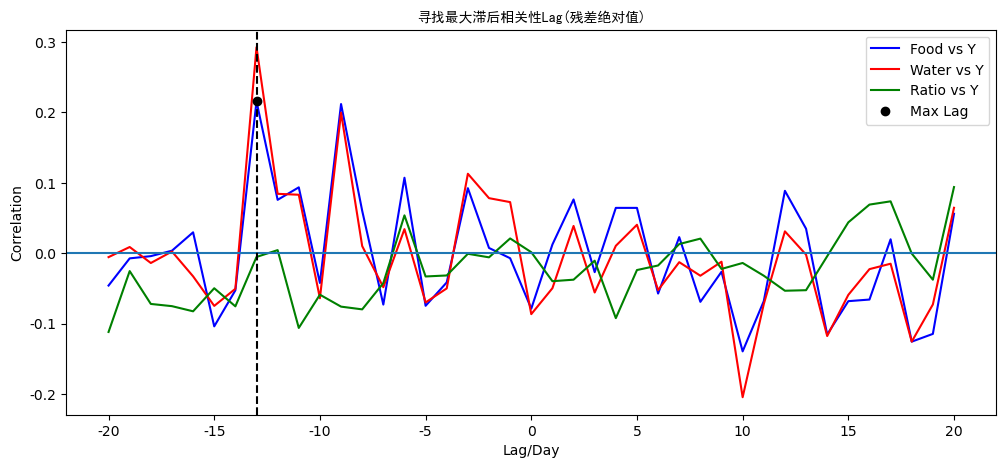

In [39]:
# def lagged_corr(x, y, max_lag=20):
#     """
#     x 和 y 在 [-max_lag, max_lag] 范围内的滞后相关性
#     """
#     lags = range(-max_lag, max_lag + 1)
#     corrs = []

#     for lag in lags:
#         corr = x.shift(lag).corr(y, method='spearman')
#         corrs.append(corr)
    
#     return pd.Series(corrs, index=lags)

lag_A_Y = lagged_corr(abs(df['food_resi']), df['y_bool'])
lag_B_Y = lagged_corr(abs(df['water_resi']), df['y_bool'])
lag_C_Y = lagged_corr(abs(df['Ratio']), df['y_bool'])

# 绘制整体lag曲线
plt.figure(figsize=(12,5))
plt.plot(lag_A_Y.index, lag_A_Y.values, color = 'blue', label='Food vs Y')
plt.plot(lag_B_Y.index, lag_B_Y.values, color = 'red', label='Water vs Y')
plt.plot(lag_C_Y.index, lag_C_Y.values, color = 'green', label='Ratio vs Y')
plt.axhline(0)
plt.xlabel("Lag/Day")
plt.ylabel("Correlation")


# 绘制最大点
max_id = abs(lag_A_Y).idxmax()
max_value = lag_A_Y[max_id]
plt.plot(max_id, max_value, 'o', color='black', label='Max Lag')
plt.axvline(max_id, linestyle='--', color='black')
plt.title('寻找最大滞后相关性Lag(残差绝对值)', fontproperties = CN_font)
plt.legend()
plt.show()

In [40]:
max_id = abs(lag_A_Y).idxmax()
max_value = lag_A_Y[max_id]

max_value

np.float64(0.2155164438174311)